# エントリ・タイミングの検討 PSAR & OBV

In [1]:
import datetime

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from func.preprocs import prepOHLC, prepTick

## データ準備

In [70]:
interval = '1m'
code = '8306'
dateStr = '20250210'

## OHLC データの読み込み

In [71]:
ohlcname = 'ohlc/ohlc_%s_%s_%s.csv' % (interval, code, dateStr)
df = pd.read_csv(ohlcname)
df_ohlc = prepOHLC(df)
df_ohlc

,Open,High,Low,Close,Volume,H_Open,H_High,H_Low,H_Close,TREND,EP,AF,PSAR,Period,Diff
Datetime,,,,,,,,,,,,,,,
2025-02-10 09:00:00,1919.0,1929.0,1918.5,1924.5,2939500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-10 09:01:00,1924.0,1926.0,1920.5,1923.0,488400.0,1922.75,1926.00,1920.5,1923.38,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-10 09:02:00,1923.0,1925.0,1918.0,1919.0,301100.0,1923.06,1925.00,1918.0,1921.25,-1.0,1918.00,0.02,1918.0,0.0,NaN
2025-02-10 09:03:00,1919.0,1920.0,1916.0,1916.5,287300.0,1922.16,1922.16,1916.0,1917.88,1.0,1916.00,0.02,1918.0,0.0,NaN
2025-02-10 09:04:00,1916.0,1917.0,1912.5,1913.5,435000.0,1920.02,1920.02,1912.5,1914.75,-1.0,1920.02,0.02,1916.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10 15:26:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-10 15:27:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-10 15:28:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## ティックデータの読み込み

In [79]:
tickname = 'tick/tick_%s_%s.csv' % (code, dateStr)
df = pd.read_csv(tickname)
df_tick = prepTick(df, dateStr)
df_tick

,Price
Datetime,
2025-02-10 09:00:00,1921.0
2025-02-10 09:00:01,1920.0
2025-02-10 09:00:04,1919.0
2025-02-10 09:00:06,1919.5
2025-02-10 09:00:08,1921.0
...,...
2025-02-10 15:24:53,1901.0
2025-02-10 15:24:55,1901.5
2025-02-10 15:24:57,1901.5


## Tick Slope

In [73]:
dict_columns = {
    't': [],
    'slope': [],
}
df_slope = pd.DataFrame.from_dict(dict_columns)
df_slope = df_slope.astype(object)

td_1m = pd.Timedelta(minutes=1)
#td_2m = pd.Timedelta(minutes=2)
dt_start = pd.to_datetime('%s 9:00:00' % dateStr)
dt_end = pd.to_datetime('%s 11:30:00' % dateStr)

while dt_start < dt_end:
    df_part = df_tick[(dt_start <= df_tick.index) & (df_tick.index <= dt_start + td_1m)].copy()
    df_part['t'] = [t.timestamp() for t in df_part.index]
    # ax + b の係数 ([a, b])
    coef = np.polyfit(df_part['t'], df_part['Price'], 1)
    
    r = len(df_slope)
    df_slope.at[r, 't'] = dt_start + td_1m
    df_slope.at[r, 'slope'] = coef[0]

    dt_start += td_1m

df_slope.index = pd.to_datetime(df_slope['t'])
df_slope.index.name = 'Datetime'
se_slope = df_slope['slope']
se_slope

Datetime
2025-02-10 09:01:00    0.116865
2025-02-10 09:02:00   -0.027907
2025-02-10 09:03:00   -0.092315
2025-02-10 09:04:00   -0.042644
2025-02-10 09:05:00   -0.048365
                         ...   
2025-02-10 11:26:00    0.010328
2025-02-10 11:27:00   -0.003835
2025-02-10 11:28:00   -0.002237
2025-02-10 11:29:00    0.002879
2025-02-10 11:30:00    0.001328
Name: slope, Length: 150, dtype: object

## Tick IQR

In [80]:
dict_columns = {
    't': [],
    'iqr': [],
}
df_iqr = pd.DataFrame.from_dict(dict_columns)
df_iqr['t'] = df_iqr['t'].astype(object)
df_iqr['iqr'] = df_iqr['iqr'].astype(float)

td_1m = pd.Timedelta(minutes=1)
td_2m = pd.Timedelta(minutes=2)
td_3m = pd.Timedelta(minutes=3)
dt_start = pd.to_datetime('%s 9:03:00' % dateStr)
dt_end = pd.to_datetime('%s 11:30:00' % dateStr)

dt_now = dt_start
while dt_now <= dt_end:
    df_part = df_tick[(dt_now - td_3m <= df_tick.index) & (df_tick.index < dt_now)].copy()
    df_part['t'] = [t.timestamp() for t in df_part.index]

    q75, q25 = np.percentile(df_part['Price'], [75, 25])
    iqr = q75 - q25
    
    r = len(df_iqr)
    df_iqr.at[r, 't'] = dt_now - td_1m
    df_iqr.at[r, 'iqr'] = iqr

    dt_now += td_1m

df_iqr.index = pd.to_datetime(df_iqr['t'])
df_iqr.index.name = 'Datetime'
se_iqr = df_iqr['iqr']
se_iqr

Datetime
2025-02-10 09:02:00    3.50
2025-02-10 09:03:00    4.50
2025-02-10 09:04:00    4.50
2025-02-10 09:05:00    2.25
2025-02-10 09:06:00    3.00
                       ... 
2025-02-10 11:25:00    0.50
2025-02-10 11:26:00    0.50
2025-02-10 11:27:00    0.50
2025-02-10 11:28:00    0.50
2025-02-10 11:29:00    0.50
Name: iqr, Length: 148, dtype: float64

## OBV の算出

In [81]:
df_ohlc['OBV'] = np.nan

dt_1h1 = pd.to_datetime('%s 9:01:00' % dateStr)
dt_1h2 = pd.to_datetime('%s 11:30:00' % dateStr)
dt_2h1 = pd.to_datetime('%s 12:30:00' % dateStr)
dt_2h2 = pd.to_datetime('%s 15:24:00' % dateStr)

obv_started = False
for t, c, v in zip(df_ohlc.index, df_ohlc['Close'], df_ohlc['Volume']):
    if (dt_1h1 <= t <= dt_1h2) or (dt_2h1 <= t <= dt_2h2):
        if obv_started:
            if c_prev < c:
                obv += v / scale
            elif c < c_prev:
                obv -= v / scale
        else:
            scale = v
            obv = 0
            obv_started = True

        df_ohlc.at[t, 'OBV'] = obv
        c_prev = c

    if t == dt_1h2:
        obv_started = False

df_ohlc

,Open,High,Low,Close,Volume,H_Open,H_High,H_Low,H_Close,TREND,EP,AF,PSAR,Period,Diff,OBV
Datetime,,,,,,,,,,,,,,,,
2025-02-10 09:00:00,1919.0,1929.0,1918.5,1924.5,2939500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-10 09:01:00,1924.0,1926.0,1920.5,1923.0,488400.0,1922.75,1926.00,1920.5,1923.38,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2025-02-10 09:02:00,1923.0,1925.0,1918.0,1919.0,301100.0,1923.06,1925.00,1918.0,1921.25,-1.0,1918.00,0.02,1918.0,0.0,NaN,-0.616503
2025-02-10 09:03:00,1919.0,1920.0,1916.0,1916.5,287300.0,1922.16,1922.16,1916.0,1917.88,1.0,1916.00,0.02,1918.0,0.0,NaN,-1.204750
2025-02-10 09:04:00,1916.0,1917.0,1912.5,1913.5,435000.0,1920.02,1920.02,1912.5,1914.75,-1.0,1920.02,0.02,1916.0,0.0,NaN,-2.095414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10 15:26:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-10 15:27:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-10 15:28:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## OBV slope

In [82]:
dict_columns = {
    't': [],
    'slope': [],
}
df_obv_slope = pd.DataFrame.from_dict(dict_columns)
df_obv_slope = df_obv_slope.astype(object)

td_1m = pd.Timedelta(minutes=1)
td_2m = pd.Timedelta(minutes=2)
td_3m = pd.Timedelta(minutes=3)
td_4m = pd.Timedelta(minutes=4)
dt_start = pd.to_datetime('%s 9:03:00' % dateStr)
#dt_end = pd.to_datetime('%s 11:30:00' % dateStr)
dt_end = pd.to_datetime('%s 11:30:00' % dateStr)

while dt_start <= dt_end:
    df_part = pd.DataFrame(df_ohlc[(dt_start - td_2m <= df_ohlc.index) & (df_ohlc.index <= dt_start)]['OBV'])
    #print(df_part)
    df_part['t'] = [t.timestamp() for t in df_part.index]
    # ax + b の係数 ([a, b])
    coef = np.polyfit(df_part['t'], df_part['OBV'], 1)
    
    r = len(df_obv_slope)
    df_obv_slope.at[r, 't'] = dt_start + td_1m
    df_obv_slope.at[r, 'slope'] = coef[0]

    dt_start += td_1m

print(df_part)
print(coef)

df_obv_slope.index = pd.to_datetime(df_obv_slope['t'])
df_obv_slope.index.name = 'Datetime'
se_obv_slope = np.abs(df_obv_slope['slope'].astype(float))
se_obv_slope

                          OBV             t
Datetime                                   
2025-02-10 11:28:00 -9.046274  1.739187e+09
2025-02-10 11:29:00 -9.046274  1.739187e+09
2025-02-10 11:30:00 -8.896601  1.739187e+09
[ 1.24726999e-03 -2.16924467e+06]


Datetime
2025-02-10 09:04:00    1.003959e-02
2025-02-10 09:05:00    1.232426e-02
2025-02-10 09:06:00    2.864797e-03
2025-02-10 09:07:00    9.418509e-04
2025-02-10 09:08:00    1.419601e-02
                           ...     
2025-02-10 11:27:00    7.592820e-04
2025-02-10 11:28:00    3.003003e-04
2025-02-10 11:29:00    2.229528e-17
2025-02-10 11:30:00    5.649090e-18
2025-02-10 11:31:00    1.247270e-03
Name: slope, Length: 148, dtype: float64

# プロット

Matplotlib では、時刻データは matplotlib.dates に従う。

https://matplotlib.org/stable/api/dates_api.html

In [83]:
# 出来高の棒グラフの幅（１分）を算出
dt1 = pd.to_datetime('%s 9:00:00' % dateStr)
mdt1 = mdates.date2num(dt1)
dt2 = pd.to_datetime('%s 15:30:00' % dateStr)
mdt2 = mdates.date2num(dt2)
td = (mdt2 - mdt1) / (6 * 60 + 30)
print(td)

0.0006944444444413351


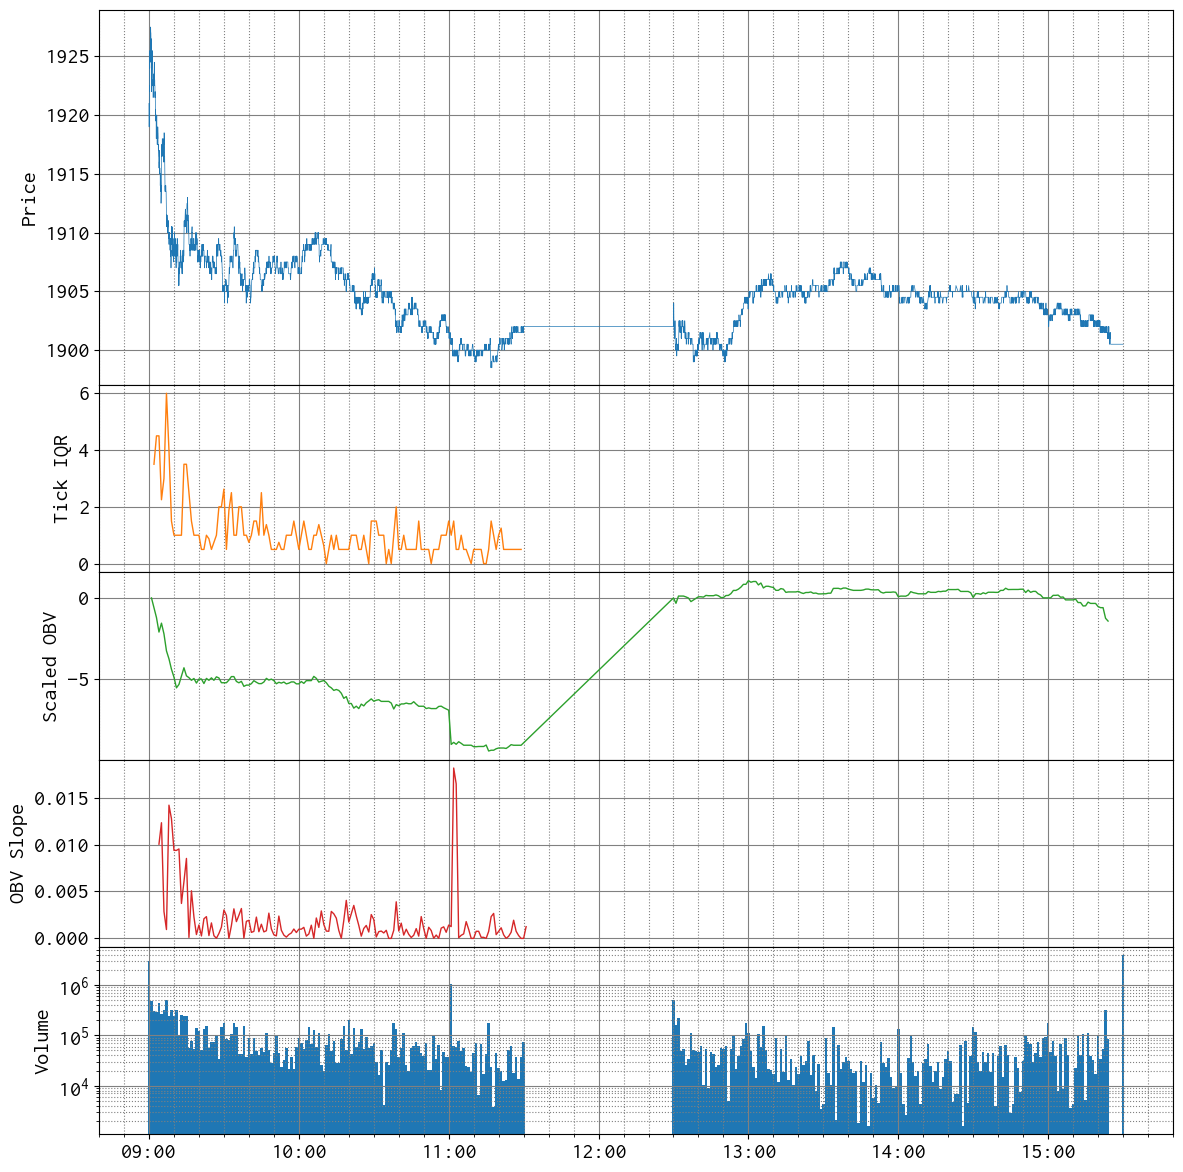

In [84]:
FONT_PATH = 'fonts/RictyDiminished-Regular.ttf'
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 12))
ax = dict()
n = 5
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    #ax[i].grid(which='both')
    ax[i].grid(visible=True, which='major', color='gray', linestyle='-')
    ax[i].grid(visible=True, which='minor', color='gray', linestyle='dotted')

# ティックデータ
ax[0].plot(
    df_tick,
    linewidth=0.5,
    color='C0',
)

ax[0].xaxis.set_major_formatter(
    mdates.DateFormatter('%H:%M')
)
ax[0].xaxis.set_minor_locator(mdates.MinuteLocator([10, 20, 30, 40, 50]))
ax[0].set_ylabel('Price')

ax[1].plot(
    se_iqr,
    linewidth=1,
    color='C1',
)
ax[1].set_ylabel('Tick IQR')

ax[2].plot(
    df_ohlc['OBV'],
    linewidth=1,
    color='C2',
)
ax[2].set_ylabel('Scaled OBV')

ax[3].plot(
    se_obv_slope,
    linewidth=1,
    color='C3',
)
ax[3].set_ylabel('OBV Slope')


td2 = pd.Timedelta(seconds=60)
ax[4].bar(
    df_ohlc.index, df_ohlc['Volume'],
    width=td2,
    align='center',
    color='C0',
)
ax[4].set_yscale('log')
ax[4].set_ylabel('Volume')

plt.tight_layout()
plt.savefig('study_007.png')
plt.show()